In [1]:
import collections
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats

from copia import chao1

In [2]:
plt.style.use('science')

# Functions

In [3]:
def chao_wor(x, q, conf=0.95):
    x = x[x > 0]
    n = x.sum() # sample size
    t = len(x)  # number of unique items
    # Convert the int64 to longs to ensure the numbers
    # don't get too big in the variance calculation
    f1 = (x == 1).sum().item() # number of singletons
    f2 = (x == 2).sum().item() # number of doubletons
    w = n / (n - 1)
    r = q / (1 - q)
    f0 = (f1 ** 2) / (2 * w * f2 + r * f1)

    # compute sd
    t1 = ((2 * w * f2 * (f0**2) + (f1**2) * f0) ** 2) / (f1 ** 5)
    t2 = (4 * (w**2) * f2) * ((f0 / f1)**4)
    var = f0 + t1 + t2
        
    z = abs(stats.norm.ppf((1 - conf) / 2))
    K = np.exp(z * np.sqrt(np.log(1 + var / f0 ** 2)))
    lci, uci = t + f0 / K, t + f0 * K
    return {
        "q": q,
        "f1": f1,
        "f2": f2,
        "f0": f0,
        "V_obs": t,
        "V_est": math.ceil(t + f0), 
        "var": var,
        "sd": np.sqrt(var),
        "lci": lci,
        "uci": uci,
        "Chao1": chao1(x)
    }

# Loading Data

In [4]:
df = pd.read_csv('../data/raw/vocapture.csv')
df.head()

,vocop_id,disambiguated_person,person_cluster_id,date_begin_contract,outward_voyage_id
0,104944,1.0,415682.0,1700-05-05,92895
1,104945,1.0,406243.0,1700-05-05,92895
2,104946,1.0,1.0,1700-05-05,92895
3,104947,1.0,77235.0,1700-05-05,92895
4,104948,1.0,65732.0,1700-05-05,92895


__vocop_id__: the unique id for each contract \
__disambiguated_person__: indicates whether the person is disambiguated (0 = no, 1 = yes). \
__person_cluster_id__: id that refers to unique person. If a person is disambiguated, multiple contracts can belong to one person \
__date_begin_contract__: start date of contract \
__outward_voyage_id__: unique id of outward voyage. 

In [5]:
print(f'total number of contracts: {df.shape[0]:,}')

total number of contracts: 774,200


In [6]:
nans = df['date_begin_contract'].isnull().sum()
print(f'number of nans in date field: {nans}')
df = df.dropna(subset=['date_begin_contract'])

number of nans in date field: 257


In [7]:
#only select disambiguated records
records = df.loc[df['disambiguated_person'] == 1, 'person_cluster_id'].astype(int).values
print(f'number of disambiguated records: {len(records):,}')

number of disambiguated records: 546,973


In [8]:
# construct year variable
df['year'] = df['date_begin_contract'].str.split('-', expand=True)[0].astype(int)
df = df.sort_values(by='year')
assert df["year"].min() == 1633 and df["year"].max() == 1794

In [9]:
df_disambiguated = df.loc[df['disambiguated_person'] == 1]
df_unique_persons = df.loc[df['disambiguated_person'] == 1].drop_duplicates(subset=['person_cluster_id'])

## plot time series




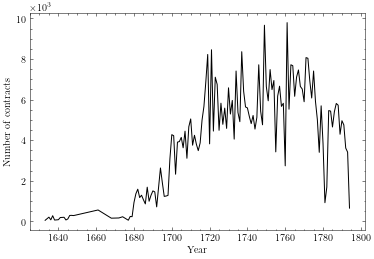

In [10]:
fig, ax = plt.subplots(figsize=(6, 4))

df_disambiguated.groupby('year')['date_begin_contract'].count().plot(ax=ax, color="k", label=None) # disambiguated
ax.set(xlabel='Year', ylabel='Number of contracts')
ax.ticklabel_format(axis="y", style="sci", scilimits=(3, 3))
plt.savefig('../figures/total_contracts.png', dpi=300)

## Calculating number of sailors on a ship

In [11]:
# remove outward_voyage_id 0
sailors_df = df[df['outward_voyage_id'] != 0]

In [12]:
# For the calculation of the median and mean, we use outward voyages to which no contracts are linked. 

mean_sailors = sailors_df.groupby(['outward_voyage_id'])['vocop_id'].count().mean()
median_sailors = sailors_df.groupby(['outward_voyage_id'])['vocop_id'].count().median()
print(f'mean sailors on a ship: {mean_sailors:.2f}')
print(f'median sailors on a ship: {median_sailors:.2f}')
n_records = 4_352

mean sailors on a ship: 244.60
median sailors on a ship: 247.00


In [13]:
from IPython.display import display, Markdown

mathprint = lambda x: display(Markdown(x))

_, counts = np.unique(records, return_counts=True)
N_obs, V_obs = counts.sum(), counts.shape[0]

#N, V = len(records), len(np.unique(records))
print(fr"The archive consists of N={N_obs:,} records and V={V_obs:,} unique sailors.")

The archive consists of N=546,973 records and V=460,274 unique sailors.


### Using Mean Sailors

In [14]:
N_est = int(mean_sailors * n_records)
mathprint(fr"$\hat{{N}}$ = {N_est:,}")

$\hat{N}$ = 1,064,487

In [15]:
q = N_obs / N_est
print(f"q = {q:.3f}")

q = 0.514


In [16]:
estimates = chao_wor(counts, q)
estimates

{'q': 0.5138371816659104,
 'f1': 401179,
 'f2': 42889,
 'f0': 315705.2121473892,
 'V_obs': 460274,
 'V_est': 775980,
 'var': 720580.4720172862,
 'sd': 848.8701149276527,
 'lci': 774319.8365583214,
 'uci': 777647.3556519173,
 'Chao1': 2336562.7429766366}

In [17]:
missing = 1 - estimates['V_obs'] / estimates['V_est']
print(f"{missing:.2%}")

40.68%


### Using Median

In [18]:
N_est = int(median_sailors * n_records)
mathprint(fr"$\hat{{N}}$ = {N_est}")

$\hat{N}$ = 1074944

In [19]:
q = N_obs / N_est
print(f"q = {q:.3f}")

q = 0.509


In [20]:
estimates = chao_wor(counts, q)
estimates

{'q': 0.5088385999642772,
 'f1': 401179,
 'f2': 42889,
 'f0': 320993.07334599714,
 'V_obs': 460274,
 'V_est': 781268,
 'var': 743535.5172261045,
 'sd': 862.2850556666888,
 'lci': 779581.470028203,
 'uci': 782961.5748538171,
 'Chao1': 2336562.7429766366}

In [21]:
missing = 1 - estimates['V_obs'] / estimates['V_est']
print(f"{missing:.2%}")

41.09%


Note that Chao1 gives an unrealistic lower bound of more than 2.3 million, which by far exceeds the know upper limit of $\hat{N}$. 

## per 25 years

In [22]:
bins = list(range(1633, 1795, 25)) + [1795]
date_ranges = [(bins[i-1], bins[i]) for i in range(1, len(bins))]
date_ranges

[(1633, 1658),
 (1658, 1683),
 (1683, 1708),
 (1708, 1733),
 (1733, 1758),
 (1758, 1783),
 (1783, 1795)]

In [23]:
DAS_voyages = [468, 586, 620, 884, 848, 718, 383]

In [24]:
estimates = collections.defaultdict(list)
V_observations = []
for index, (start, end) in enumerate(date_ranges):
    df_slice = sailors_df[sailors_df['year'].between(start, end, inclusive="left")]
    records = df_slice.loc[df_slice['disambiguated_person'] == 1, 'person_cluster_id'].astype(int).values
    _, counts = np.unique(records, return_counts=True)
    N, V_obs = counts.sum(), counts.shape[0]
    V_observations.append(V_obs)
    for aggregation in ('mean', 'median'):
        agg_sailors = int(df_slice.groupby(['outward_voyage_id'])['vocop_id'].count().agg(aggregation))
        N_est = DAS_voyages[index] * agg_sailors
        q = len(records) / N_est
        estimate = chao_wor(counts, q)
        estimate["N_est"] = N_est
        estimate["period"] = f"{start} - {end}"
        estimate[f"{aggregation} sailors"] = agg_sailors
        estimate["voyages"] = DAS_voyages[index]
        estimate["records"] = len(records)
        estimates[aggregation].append(estimate)

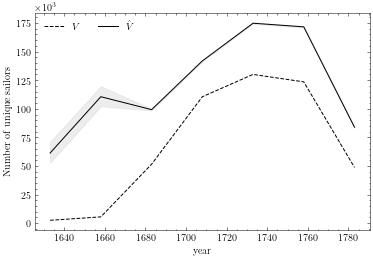

In [25]:
labels = [x[0] for x in date_ranges]

fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(labels, V_observations, label=r'$V$', color="k", linestyle='dashed')
lci, uci, est = zip(*[(est["lci"], est["uci"], est["V_est"]) for est in estimates["mean"]])
ax.plot(labels, est, color="k", label=r'$\hat{V}$')
ax.fill_between(labels, lci, uci, color="lightgrey", alpha=0.4)
ax.set(xlabel='year', ylabel='Number of unique sailors')
ax.ticklabel_format(axis="y", style="sci", scilimits=(3, 3))
ax.legend(ncol=2)
plt.savefig('../figures/25year_plot_mean.png', dpi=300)

### Median Sailors

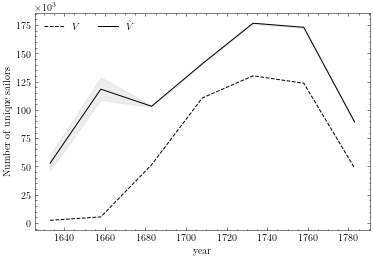

In [26]:
labels = [x[0] for x in date_ranges]

fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(labels, V_observations, label=r'$V$', color="k", linestyle='dashed')
lci, uci, est = zip(*[(est["lci"], est["uci"], est["V_est"]) for est in estimates["median"]])
ax.plot(labels, est, color="k", label=r'$\hat{V}$')
ax.fill_between(labels, lci, uci, color="lightgrey", alpha=0.4)
ax.set(xlabel='year', ylabel='Number of unique sailors')
ax.ticklabel_format(axis="y", style="sci", scilimits=(3, 3))
ax.legend(ncol=2)
plt.savefig('../figures/25year_plot_median.png', dpi=300)

## LaTeX tables

In [70]:
interesting_columns = ['period', 'voyages', 'q', 'N_est', 'V_obs', 'V_est', 'lci', 'uci', 'loss rate', 'Chao1']
formatters = {
    "q": lambda x: f"{x:.2f}",
    "loss rate": lambda x: f"{x:.2%}",
}
for column in ('voyages', 'N_est', 'V_obs', 'V_est', 'lci', 'uci', 'Chao1'):
    formatters[column] = lambda x: f"{x:,.0f}"

def format_column(x):
    return x if isinstance(x, str) else f"{x:,.0f}"

estimates_df = pd.DataFrame(estimates["mean"])
estimates_df["loss rate"] = 1 - estimates_df["V_obs"] / estimates_df["V_est"]
print(estimates_df[interesting_columns].to_latex(formatters=formatters))

\begin{tabular}{llrrrrrrrrr}
\toprule
{} &       period & voyages &    q &   N\_est &   V\_obs &   V\_est &     lci &     uci & loss rate &   Chao1 \\
\midrule
0 &  1633 - 1658 &     468 & 0.03 &  84,708 &   2,457 &  61,306 &  52,944 &  71,052 &    95.99\% & 215,522 \\
1 &  1658 - 1683 &     586 & 0.04 & 140,640 &   5,462 & 110,562 & 102,170 & 119,680 &    95.06\% & 497,150 \\
2 &  1683 - 1708 &     620 & 0.46 & 120,280 &  51,501 &  99,253 &  98,573 &  99,941 &    48.11\% & 409,425 \\
3 &  1708 - 1733 &     884 & 0.74 & 177,684 & 110,517 & 141,842 & 141,435 & 142,254 &    22.08\% & 540,560 \\
4 &  1733 - 1758 &     848 & 0.70 & 212,848 & 130,069 & 174,854 & 174,353 & 175,359 &    25.61\% & 725,923 \\
5 &  1758 - 1783 &     718 & 0.66 & 221,862 & 123,553 & 171,669 & 171,129 & 172,215 &    28.03\% & 574,654 \\
6 &  1783 - 1795 &     383 & 0.52 & 104,559 &  48,738 &  83,897 &  83,352 &  84,449 &    41.91\% & 293,352 \\
\bottomrule
\end{tabular}



In [71]:
estimates_df = pd.DataFrame(estimates["median"])
estimates_df["loss rate"] = 1 - estimates_df["V_obs"] / estimates_df["V_est"]
estimates_df[interesting_columns]
print(estimates_df[interesting_columns].to_latex(formatters=formatters))

\begin{tabular}{llrrrrrrrrr}
\toprule
{} &       period & voyages &    q &   N\_est &   V\_obs &   V\_est &     lci &     uci & loss rate &   Chao1 \\
\midrule
0 &  1633 - 1658 &     468 & 0.04 &  69,264 &   2,457 &  52,869 &  46,572 &  60,064 &    95.35\% & 215,522 \\
1 &  1658 - 1683 &     586 & 0.04 & 153,532 &   5,462 & 118,287 & 108,727 & 128,730 &    95.38\% & 497,150 \\
2 &  1683 - 1708 &     620 & 0.44 & 126,480 &  51,501 & 103,185 & 102,450 & 103,929 &    50.09\% & 409,425 \\
3 &  1708 - 1733 &     884 & 0.75 & 175,916 & 110,517 & 140,730 & 140,333 & 141,132 &    21.47\% & 540,560 \\
4 &  1733 - 1758 &     848 & 0.70 & 215,392 & 130,069 & 176,523 & 176,010 & 177,042 &    26.32\% & 725,923 \\
5 &  1758 - 1783 &     718 & 0.66 & 224,016 & 123,553 & 172,909 & 172,358 & 173,465 &    28.54\% & 574,654 \\
6 &  1783 - 1795 &     383 & 0.47 & 114,134 &  48,738 &  89,463 &  88,837 &  90,098 &    45.52\% & 293,352 \\
\bottomrule
\end{tabular}

